# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

***Описание данных***

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.
В нашем распоряжении одна папка со всеми изображениями (/final_files) и csv-файл labels.csv с двумя колонками: file_name и real_age.

***План работы***

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Построить и обучить свёрточную нейронную сеть. Добиться значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import plotly.express as px

RAST=33

Загрузим таблицу с наименованием файлов с фотографиями и указанием возраста человека на них

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

Выведем первые 10 строк

In [3]:
display(labels.head(10))

file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
5  000005.jpg        27
6  000006.jpg        24
7  000007.jpg        43
8  000008.jpg        26
9  000009.jpg        39

Выведем общую информацию

In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


У нас имеется 7591 запись о наименовании фотографий людей с указанием возраста. Пропуски отсутствуют. Проверим наличие дубликатов.

In [5]:
print(f'Количество дубликатов: {labels.duplicated().sum()}')

Количество дубликатов: 0


Выведем сатистические показатели по целевому признаку

In [6]:
display(labels.describe())

real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000

В папке с изображениями находятся фотографии людей возрастом от 1 года до 100 лет. Большая часть возрастом не более 41 года. Выведем график распределения возрастов

In [7]:
fig = px.histogram(labels, x='real_age', width=1000, height=700,\
                   color_discrete_sequence=['darkslategrey'], marginal='box', range_x=(0, 101))
fig.update_layout(title_text='График распределения возраста в выборке',\
                  title_font_size=20, title_x = 0.5,\
                  xaxis_title_text='Возраст', yaxis_title_text='Количество изображений',\
                  bargap=0.05)
fig.show()

Наибольшее количество фотографий имеется по людям возрастом от 14 до 40 лет, а так же возрастом 1 год и 50 лет. Очень мало фотографий по людям возрастом старше 70 лет, а старше 90 ихсовсем единицы. Кроме того в промежутке от 1 до 100 лет отсутствуют фотографии людей возрастом 92, 98 и 99 лет.

Найдем максимальный и минимальный размер изображения

In [8]:
dict_size = {'max_size':[(0, 0, 0), None, 1], 'min_size':[(9999, 9999, 9999), None, 2]}
for i in labels['file_name']:
    array = np.array(Image.open('/datasets/faces/final_files/' + i))
    if array.shape > dict_size['max_size'][0]:
        dict_size['max_size'][0] = array.shape
        dict_size['max_size'][1] = i
    elif array.shape < dict_size['min_size'][0]:
        dict_size['min_size'][0] = array.shape
        dict_size['min_size'][1] = i

Выведем эти изображения

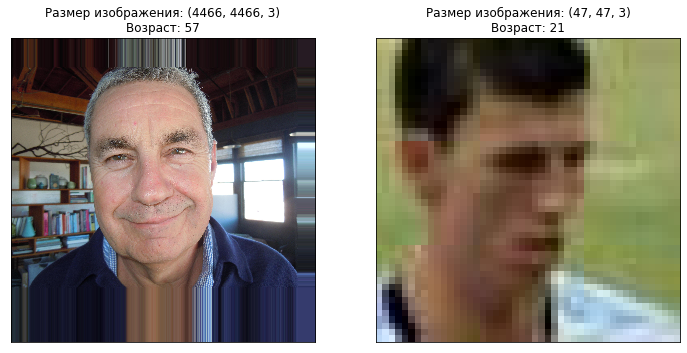

In [9]:
fig = plt.figure(figsize=(12, 12))
for key in dict_size:
    age = labels.loc[labels['file_name'] == dict_size[key][1], 'real_age'].iloc[0]
    fig.add_subplot(1, 2, dict_size[key][2])
    plt.imshow(np.array(Image.open('/datasets/faces/final_files/' + dict_size[key][1])))
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Размер изображения: {dict_size[key][0]}' + '\n' + f'Возраст: {age}')

Количество пикселей у изображения с лучшим разрешением примерно в 9000 раз больше чем у изображения с минимальным разрешением. В нашей выборке изображения имеют различные размеры.

Подготовим генератор данных изображений с количеством батчей равным 16 и приводимым размером изображений 224х224.

In [10]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels,\
                                                   directory='/datasets/faces/final_files/',\
                                                   x_col='file_name', y_col='real_age',\
                                                   target_size=(224, 224), batch_size=16,\
                                                   class_mode='raw', seed=RAST)

Found 7591 validated image filenames.


Выведем первые 16 изображений из генератора

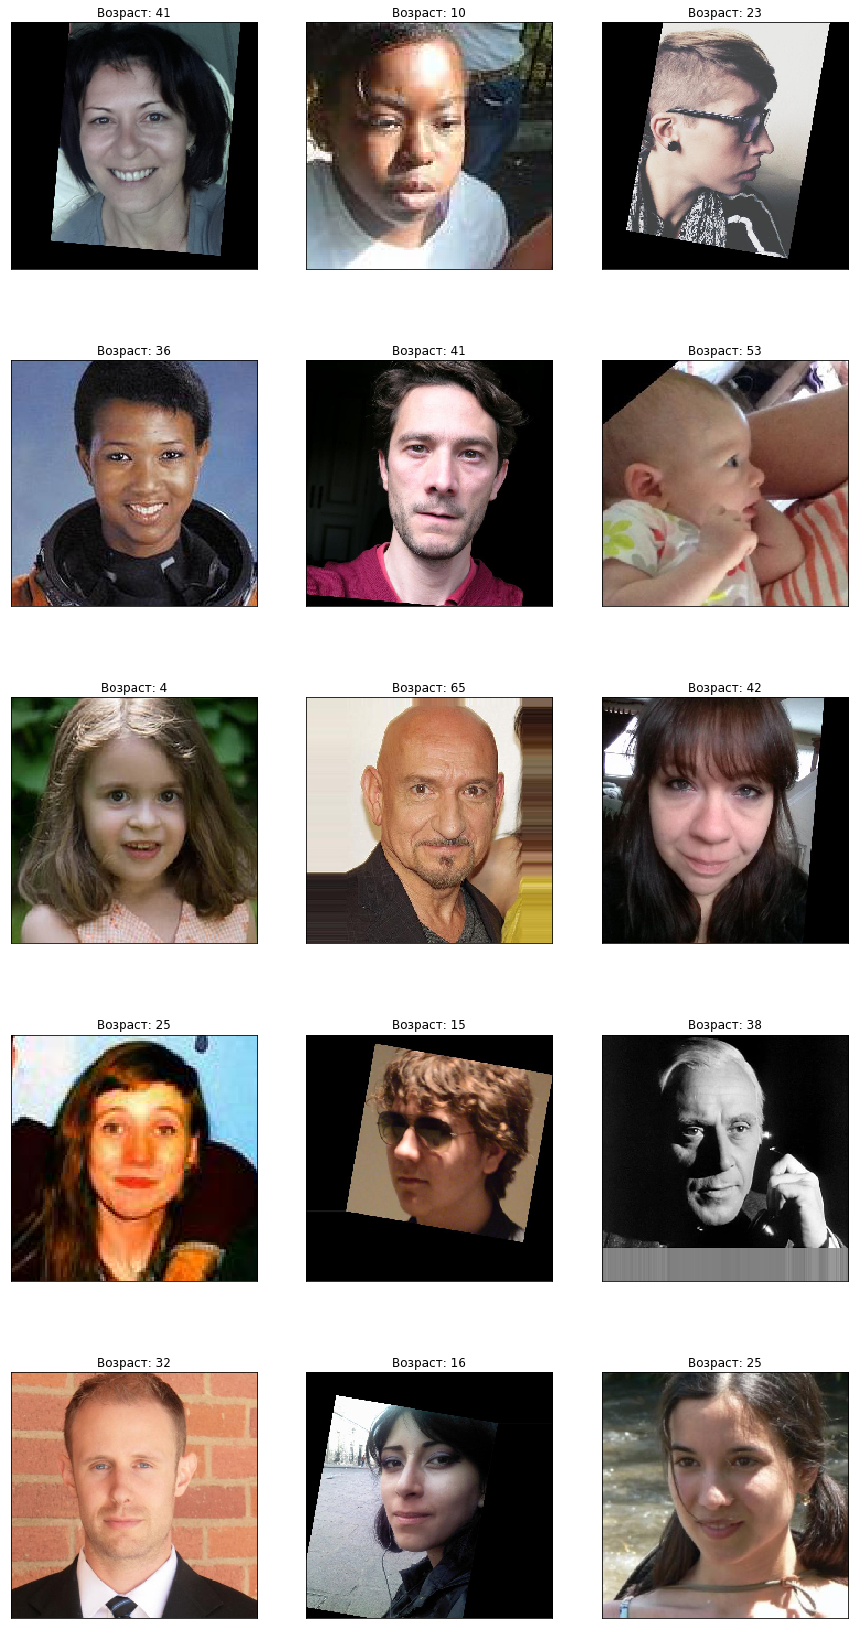

In [11]:
X, y = next(train_gen_flow)
fig = plt.figure(figsize=(15, 30))
for i in range(len(y)-1):
    age = y[i]
    fig.add_subplot(5, 3, i+1)
    plt.imshow(X[i])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'Возраст: {age}')

К некоторым изображениям в выборке применены различные искажения: сдвиги в различных направлениях, обрезания под различным углом и добавление темного фона, возможно искажение цвета.

## Обучение модели

Код для обучения модели в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в ячейке Markdown

```
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


def load_train(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.2,
        rescale= 1 / 255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
                            dataframe=labels,
                            directory='/datasets/faces/final_files/',
                            x_col='file_name', y_col='real_age',
                            target_size=(224, 224),
                            batch_size=32,
                            subset='training',
                            class_mode='raw',
                            seed=33)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv('/datasets/faces/labels.csv')

    test_datagen = ImageDataGenerator(validation_split=0.2, rescale=1 / 255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
                            dataframe=labels,
                            directory='/datasets/faces/final_files/',
                            x_col='file_name', y_col='real_age',
                            target_size=(224, 224),
                            batch_size=32,
                            subset='validation',
                            class_mode='raw',
                            seed=33)

    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    optimizer = Adam(lr=0.00007)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
    model.summary()

    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=30,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

Результат вывода модели:

```
Found 6073 validated image filenames.
Found 1518 validated image filenames.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 190 steps, validate for 48 steps
Epoch 1/30
190/190 - 93s - loss: 316.1235 - mae: 12.5798 - val_loss: 668.6090 - val_mae: 20.8833
Epoch 2/30
190/190 - 36s - loss: 68.9408 - mae: 6.2227 - val_loss: 578.7598 - val_mae: 19.0175
Epoch 3/30
190/190 - 36s - loss: 31.3919 - mae: 4.3258 - val_loss: 235.6793 - val_mae: 11.3862
Epoch 4/30
190/190 - 36s - loss: 19.7314 - mae: 3.4189 - val_loss: 101.4983 - val_mae: 7.6371
Epoch 5/30
190/190 - 36s - loss: 14.6065 - mae: 2.9541 - val_loss: 71.1916 - val_mae: 6.4764
Epoch 6/30
190/190 - 36s - loss: 11.8575 - mae: 2.6529 - val_loss: 109.8300 - val_mae: 8.4498
Epoch 7/30
190/190 - 36s - loss: 10.6870 - mae: 2.5079 - val_loss: 68.4626 - val_mae: 6.3261
Epoch 8/30
190/190 - 36s - loss: 8.9952 - mae: 2.2668 - val_loss: 69.4561 - val_mae: 6.3915
Epoch 9/30
190/190 - 36s - loss: 8.3751 - mae: 2.1687 - val_loss: 69.6453 - val_mae: 6.2844
Epoch 10/30
190/190 - 36s - loss: 7.4266 - mae: 2.0631 - val_loss: 64.6774 - val_mae: 6.1455
Epoch 11/30
190/190 - 36s - loss: 5.9914 - mae: 1.8240 - val_loss: 65.7406 - val_mae: 6.2299
Epoch 12/30
190/190 - 36s - loss: 4.7947 - mae: 1.6542 - val_loss: 64.0791 - val_mae: 6.0718
Epoch 13/30
190/190 - 36s - loss: 4.5437 - mae: 1.6185 - val_loss: 69.8139 - val_mae: 6.2194
Epoch 14/30
190/190 - 36s - loss: 4.3549 - mae: 1.5814 - val_loss: 64.5226 - val_mae: 6.1488
Epoch 15/30
190/190 - 36s - loss: 4.2385 - mae: 1.5422 - val_loss: 65.3742 - val_mae: 6.1326
Epoch 16/30
190/190 - 36s - loss: 4.1999 - mae: 1.5426 - val_loss: 63.8579 - val_mae: 6.1058
Epoch 17/30
190/190 - 36s - loss: 4.6818 - mae: 1.6204 - val_loss: 65.1628 - val_mae: 6.0700
Epoch 18/30
190/190 - 36s - loss: 5.2940 - mae: 1.7324 - val_loss: 63.6459 - val_mae: 6.1187
Epoch 19/30
190/190 - 36s - loss: 5.4746 - mae: 1.7544 - val_loss: 62.0974 - val_mae: 5.8901
Epoch 20/30
190/190 - 36s - loss: 5.3141 - mae: 1.7464 - val_loss: 61.7975 - val_mae: 5.9863
Epoch 21/30
190/190 - 36s - loss: 5.0047 - mae: 1.7086 - val_loss: 64.4284 - val_mae: 6.1765
Epoch 22/30
190/190 - 36s - loss: 4.5164 - mae: 1.6006 - val_loss: 62.9840 - val_mae: 5.8942
Epoch 23/30
190/190 - 36s - loss: 4.4006 - mae: 1.5684 - val_loss: 64.1875 - val_mae: 6.0500
Epoch 24/30
190/190 - 36s - loss: 4.1903 - mae: 1.5397 - val_loss: 61.0986 - val_mae: 5.9049
Epoch 25/30
190/190 - 36s - loss: 3.6899 - mae: 1.4700 - val_loss: 62.7541 - val_mae: 6.0445
Epoch 26/30
190/190 - 36s - loss: 3.2991 - mae: 1.3737 - val_loss: 65.4191 - val_mae: 6.0495
Epoch 27/30
190/190 - 36s - loss: 3.1066 - mae: 1.3222 - val_loss: 62.4723 - val_mae: 5.9818
Epoch 28/30
190/190 - 36s - loss: 3.4422 - mae: 1.4034 - val_loss: 59.0182 - val_mae: 5.7794
Epoch 29/30
190/190 - 36s - loss: 4.1986 - mae: 1.5291 - val_loss: 67.0546 - val_mae: 6.2429
Epoch 30/30
190/190 - 36s - loss: 4.8688 - mae: 1.6728 - val_loss: 62.3419 - val_mae: 5.8795
48/48 - 7s - loss: 62.3419 - mae: 5.8795
Test MAE: 5.8795
```

## Анализ обученной модели

Для обучения модели мы использовали предобученную на большом датасете ImageNet архитектуру ResNet с количеством слоев равным 50, оставив от нее только костяк. Коэффициент скорости обучения мы указали 0.00007, количество батчей, подаваемых на вход модели за раз - 32, а количество эпох - 30. В качестве функции потерь мы использовали mse, алгоритм обучения - Adam, а метрика качества на валидационной выборке - mae. Так как мы начали обучение не со случайных весов, уже по итогам четвертой эпохи мы достигли необходимого показателя метрики качества MAE - 7.64 (по заданию значения MAE на тестовой выборке должно быть не больше 8).

По итогам 30-ти эпох мы получили показатель метрики качества MAE равный 5.88, что говорит о том что дообученная нами модель в среднем ошибается при определении возраста на изображении не более чем на 6 лет. Считаю что модель с достигнутой метрикой качества по большей части успешно будет справляться с рекомендацией товаров в зависимости от возрастной группы покупателя. Но, по моему мнению, для второй задачи, а именно определение возраста покупателя при продаже ему алкоголя, модель с таким значением MAE не подходит. Учитывая среднюю ошибку определения возраста в 6 лет, модель вероятно нередко будет помечать подростков до 18 лет как взрослого человека, и наоборот. Возможно для этого необходима другая метрика качества, и решение не регрессионной задачи, а задачи бинарной классификации. С другой стороны, само знание у кассиров о наличии такой модели уже заметно снизит риск продажи алкоголя несовершеннолетним.